# Imports

In [1]:
![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gnganesh99/im2spec_bnn/blob/main/notebooks/pbnn_im2spec.ipynb)


'[Open' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import NeuroBayes.neurobayes as nb
from sklearn.model_selection import train_test_split
import numpy as np
import jax.numpy as jnp
import jax


import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
from flax.training import train_state
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import jax.random as random
import numpy as np
import haiku as hk

from flax.training import train_state
from typing import Any, Callable, Dict, Tuple

from NeuroBayes.neurobayes.flax_nets import FlaxConvNet


In [2]:
from im2spec_models import *
from BEPS_functions import *
from im2spec_dataset import *
from plot_functions import *

# Get data

In [3]:
beps_file = r"BEPS_data/PTO_BEPS_1um.npz"

full_image, spectra, v_step = extract_beps_data(beps_file)
print("Value Range:", full_image.min(), full_image.max(), spectra.min(), spectra.max())

spec_pixel_x1 = 10; spec_pixel_y1 = 10
spec_pixel_x2 = 40; spec_pixel_y2 = 40

# Plot image and spectra at selected locations
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2), dpi = 150)
# plt.subplots_adjust(wspace=0.5)

# ax1.imshow(full_image, origin = "lower")
# ax1.scatter(spec_pixel_x1, spec_pixel_y1, marker='X', s=100, c='k')
# ax1.scatter(spec_pixel_x2, spec_pixel_y2, marker='X', s=100, c='r')
# ax1.set_title('Structure Image')
# ax1.axis("off")

# ax2.set_title("Spectra at selected locations")  # Note: Convention of the spectra indices is reversed!!!
# ax2.plot(v_step, spectra[spec_pixel_y1, spec_pixel_x1], c = 'k')
# ax2.plot(v_step, spectra[spec_pixel_y2, spec_pixel_x2], c = 'r')
# ax2.set_xlabel('Voltage (V)')
# ax2.set_ylabel('Piezoresponse (a.u.)')

Value Range: 0.0 1.0 0.0 1.0


In [4]:
#images, spectra, coordinates = paired_images_spectra_1(full_image, cits_obj, hyperspectra, window_size = 20, coordinate_step = 10, image_norm=False, spectra_norm = False)
window_size = 16
images, spectra, coordinates, vstep = BEPS_image_spectral_pairs(beps_file, window_size = window_size, add_channel_NHWC=True)

print(images.shape, spectra.shape, vstep.shape)
h,w = images.shape[1], images.shape[2]
target_dim = spectra.shape[1]

# fig, ax = plt.subplots(1, 3, figsize = (15, 4))

# idx = 10

# ax[0].imshow(full_image, origin = 'lower')
# ax[0].scatter(coordinates[idx, 1], coordinates[idx, 0], c ="r")
# ax[0].set_title("Sample image")


# im = ax[1].imshow(images[idx], origin = 'lower')
# fig.colorbar(im, ax=ax[1])
# ax[1].set_title(f"Patch at index {idx}")
# ax[2].plot(vstep, spectra[idx])
# ax[2].set_title(f"Patch at index {idx}")

# plt.show()

(1225, 16, 16, 1) (1225, 256) (256,)


In [58]:

in_dim = images[0].shape  # Input dimensions (image height and width)
out_dim = len(spectra[0])  # Output dimensions (spectra length)

test_size = 0.8


indices = np.arange(len(images))
imgs_train,imgs_test, spectra_train, spectra_test, indices_train, indices_test = train_test_split(images, spectra, indices, test_size = test_size, random_state = 24)

print(imgs_train.shape, spectra_train.shape, imgs_test.shape, spectra_test.shape)
initial_trainsize = imgs_train.shape[0]

(245, 16, 16, 1) (245, 256) (980, 16, 16, 1) (980, 256)


# Functions

In [50]:
def spectral_mismatch_error(pred_spectra, spectra):

    mse = np.mean(np.abs((pred_spectra - spectra)), axis=1)
    
    return mse

def norm_0to1(arr):
    arr = np.asarray(arr)
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    return arr

def distance_acq_fn(distances, beta = 0.5, lambda_ = 1, optimize = "custom_fn", sample_next_points = 10, exclude_indices = []):

    distances = np.ravel(np.asarray(distances))
    acq_vals = norm_0to1(distances) 
    
    
    
    if optimize == "minimize":
        
        aq_vals[exclude_indices] = 2
        aq_ind = np.argsort(acq_vals)
        

    elif optimize == "maximize":
        
        aq_vals[exclude_indices] = -1
        aq_ind = np.argsort(acq_vals)[::-1]

    elif optimize == "custom_fn":

                    # EXPLORATION + EXPLOITATION
        acq_vals = (1-np.exp(-lambda_ * np.abs(acq_vals-(1-beta))))
        acq_vals = norm_0to1(acq_vals) 
        
        #acq_vals = beta*(1- np.exp(-lambda_ * distances)) + (1-beta)*np.exp(-lambda_ * distances)

        acq_vals[exclude_indices] = -1
        aq_ind = np.argsort(acq_vals)[::-1]

    else:
        raise ValueError('Invalid optimization type')
    

    aq_ind = aq_ind[:sample_next_points]


    return aq_ind, acq_vals

def append_training_set(images, spectra, next_index, imgs_train, spectra_train, indices_train):

    imgs_train = np.append(imgs_train, images[next_index].reshape(1, images.shape[1], images.shape[2], 1), axis = 0)

    spectra_train = np.append(spectra_train, spectra[next_index].reshape(1, spectra.shape[1]), axis = 0)
    
    indices_train = np.append(indices_train, next_index)

    return imgs_train, spectra_train, indices_train

def train_model(architecture, probabilistic_layer_names, images_train, spectra_train, warmup_epochs = 1000, sample_epochs = 1000):
    
    model = nb.PartialBNN(architecture, probabilistic_layer_names= probabilistic_layer_names)

    model.fit(images_train, spectra_train, num_warmup=warmup_epochs, num_samples=sample_epochs)

    return model


def augmented_dataset_numpy(images, spectra):

    images = images[:, :, :, 0]

    dataset = augmented_dataset(images, spectra)
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    for images, spectra in dataloader:
        images = images.numpy()
        spectra = spectra.numpy()

    images = images[..., np.newaxis]

    return images, spectra
    

    
    

# PBNN Model

In [56]:
#architecture = im2spec(target_size = 128, latent_dim = 3, nb_filters = 64)
architecture = FlaxConvNet(input_dim = 1, conv_layers = [32,64,64], fc_layers=[16, 32, 64, 128], target_dim=target_dim,  conv_dropout= 0.5, hidden_dropout = 0.3, output_dropout = 0.0)

# Add channel dimension to match the expected input shape
inputs = jnp.ones((1, h, w, 1))  # Shape: (batch_size, height, width, channels)
#model_tab = architecture.tabulate(jax.random.PRNGKey(0), inputs, console_kwargs={"width": 200, "force_jupyter": True})


In [57]:
# Specify the names of probabilistic layers (output layer, 'Dense4', needs to be specified explicitly)
probabilistic_layer_names = [' ConvLayerModule_0/Conv0', 'FlaxMLP_0/MLPLayerModule_0/Dense0', 'FlaxMLP_0/MLPLayerModule_3/Dense3']  # MLP  

# Intitalize and train a PBNN model
model = nb.PartialBNN(architecture, probabilistic_layer_names=probabilistic_layer_names)

#images_to_train, spectra_to_train = augmented_dataset_numpy(imgs_train, spectra_train)
images_to_train, spectra_to_train = imgs_train, spectra_train


print("Training set shape:", images_to_train.shape, spectra_to_train.shape)

model.fit(images_to_train, spectra_to_train, num_warmup=1000, num_samples=1000)

Training set shape: (71, 16, 16, 1) (71, 256)
Training deterministic NN...


Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 500/500 [00:20<00:00, 24.90it/s, Epoch 500/500, LR: 0.010000, Loss: 0.0802 ]


Training partially Bayesian NN


sample: 100%|██████████| 20/20 [00:01<00:00, 13.73it/s, 3 steps of size 7.28e-03. acc. prob=0.84]


(1225, 256) (1225, 256) (1225,) (1225,)
Spectral Mismatch Error: 0.20907162


Text(0, 0.5, 'Model predicted Variance')

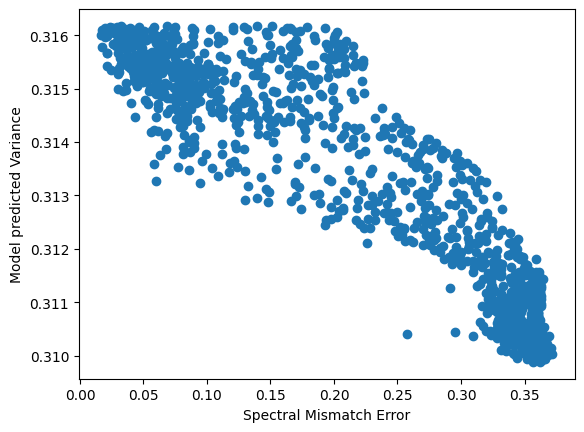

In [9]:
posterior_mean, posterior_var = model.predict(images)
cumulative_var = np.mean(posterior_mean, axis=1)


spectral_error = spectral_mismatch_error(posterior_mean, spectra)
print(posterior_mean.shape, posterior_var.shape, cumulative_var.shape, spectral_error.shape)
print("Spectral Mismatch Error:", spectral_error.mean())

plt.scatter(spectral_error, cumulative_var)
plt.xlabel("Spectral Mismatch Error")
plt.ylabel("Model predicted Variance")


Index: 538


Text(0, 0.5, 'Signal (a.u.)')

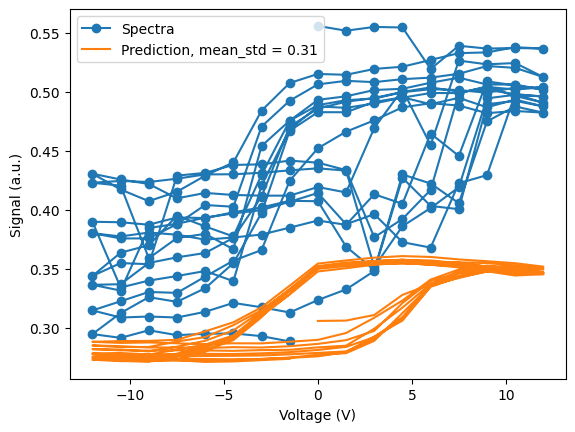

In [10]:
#ind = random.randint(minval= 0, maxval=len(spectra_test), 1)
import random
ind = random.choice(indices_test)
print("Index:", ind)

plt.plot(vstep, spectra[ind], 'o-', label="Spectra")
plt.plot(vstep, posterior_mean[ind], label=f'Prediction, mean_std = {cumulative_var[ind]:.2f}')
plt.legend()

plt.xlabel('Voltage (V)')
plt.ylabel('Signal (a.u.)')


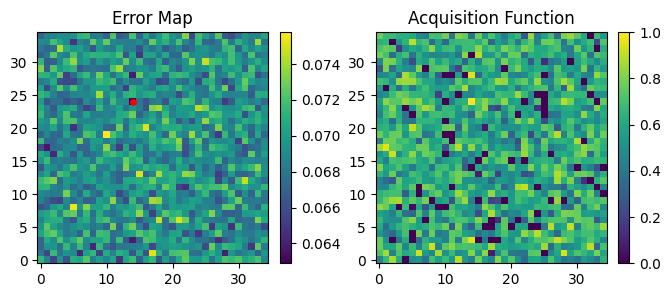

IndexError: index 854 is out of bounds for axis 0 with size 1

In [55]:
aq_ind, aq_vals = distance_acq_fn(cumulative_var, beta = 0, lambda_ = 1, optimize = "custom_fn", sample_next_points = 1, exclude_indices = indices_train)

plot_error_prediction(cumulative_var, aq_vals, coordinates, aq_ind)
for ind in aq_ind:
    plot_spectra([posterior_mean[ind]], spectra[ind], spectral_error[ind], xdata = vstep)

# Active learning

In [53]:
beta = 1
test_size = 0.95
lambda_ = 0.1
sample_next_points = 5
augment_dataset = True


imgs_train, imgs_test, spectra_train, spectra_test, indices_train, indices_test = train_test_split(images, spectra, indices, test_size = test_size, random_state = 24)
print("Train/Test split:", imgs_train.shape, imgs_test.shape, spectra_train.shape, spectra_test.shape)

architecture = FlaxConvNet(input_dim = 2, conv_layers = [32,64,64], fc_layers=[32, 64, 128], target_dim=target_dim,  conv_dropout= 0.5, hidden_dropout = 0.3, output_dropout = 0.1)
probabilistic_layer_names = [' ConvLayerModule_0/Conv0', 'FlaxMLP_0/MLPLayerModule_0/Dense0', 'FlaxMLP_0/MLPLayerModule_3/Dense3']
#probabilistic_layer_names = ['FlaxMLP_0/MLPLayerModule_3/Dense3']  # MLP  ' ConvLayerModule_0/Conv0', 'FlaxMLP_0/MLPLayerModule_0/Dense0',

Train/Test split: (61, 16, 16, 1) (1164, 16, 16, 1) (61, 256) (1164, 256)


Training set shape: (183, 16, 16, 1) (183, 256)
Training deterministic NN...


Training Progress: 100%|██████████| 500/500 [00:24<00:00, 20.49it/s, Epoch 500/500, LR: 0.010000, Loss: 0.0587 ]


Training partially Bayesian NN


sample: 100%|██████████| 20/20 [00:01<00:00, 10.95it/s, 3 steps of size 3.12e-03. acc. prob=0.93]


(1, 256) (1, 256)


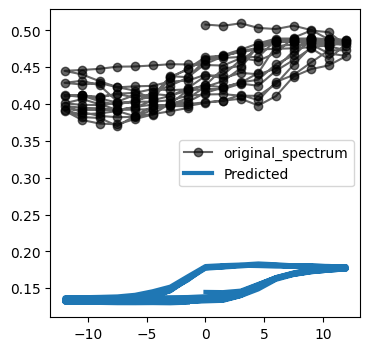

(1, 256) (1, 256)


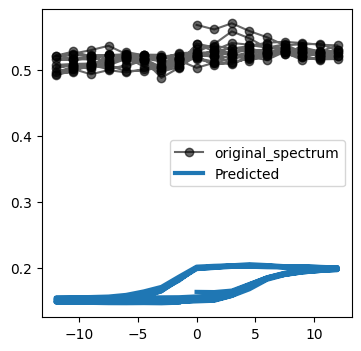

(1, 256) (1, 256)


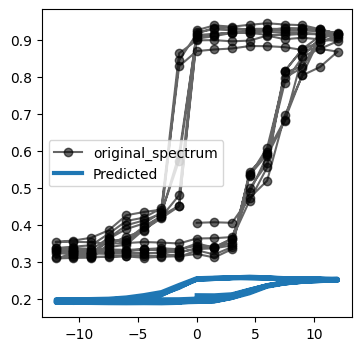

(1, 256) (1, 256)


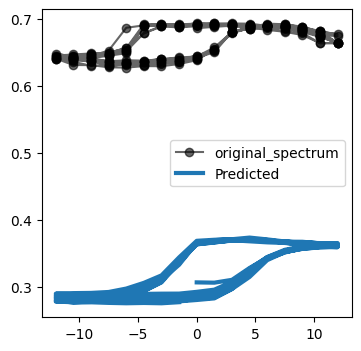

(1, 256) (1, 256)


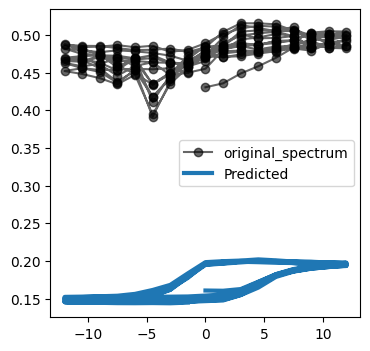

(66, 16, 16, 1) (66, 256) (66,)
Training set shape: (198, 16, 16, 1) (198, 256)
Training deterministic NN...


Training Progress: 100%|██████████| 500/500 [00:28<00:00, 17.48it/s, Epoch 500/500, LR: 0.010000, Loss: 0.0571 ]


Training partially Bayesian NN


sample: 100%|██████████| 20/20 [00:01<00:00, 12.60it/s, 3 steps of size 4.62e-03. acc. prob=0.82]


(1, 256) (1, 256)


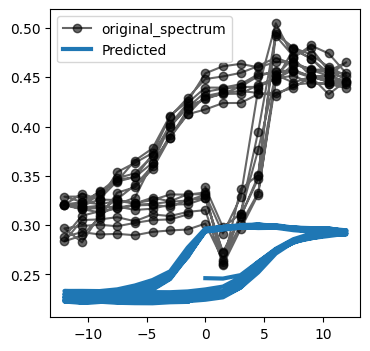

(1, 256) (1, 256)


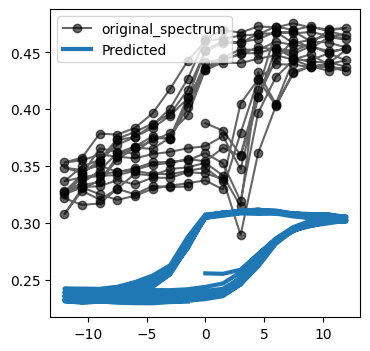

(1, 256) (1, 256)


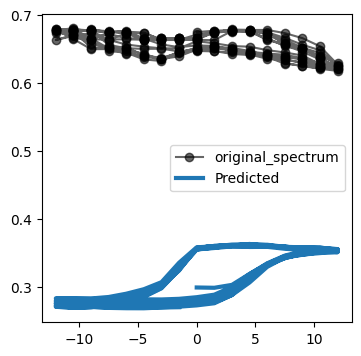

(1, 256) (1, 256)


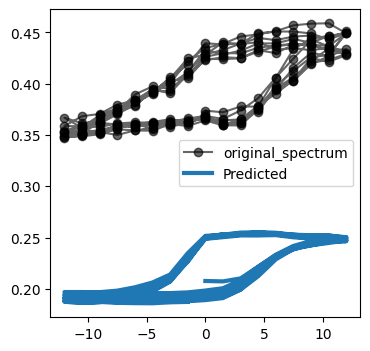

(1, 256) (1, 256)


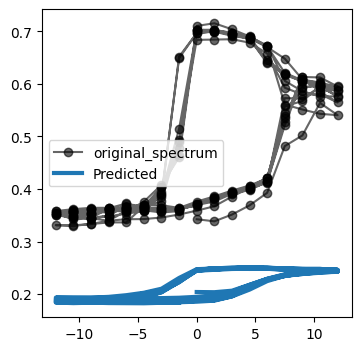

(71, 16, 16, 1) (71, 256) (71,)


In [54]:
exploration_steps = 2
error_log = []
random_error_log = []
trainset_errors = []
testset_errors = []
fitting_errors = []
pred_errors =[]


for i in range(exploration_steps):

    # Train the model

    if augment_dataset:
        images_to_train, spectra_to_train = augmented_dataset_numpy(imgs_train, spectra_train)
    else:
        images_to_train, spectra_to_train = imgs_train, spectra_train

    print("Training set shape:", images_to_train.shape, spectra_to_train.shape)

    # model = nb.PartialBNN(architecture, probabilistic_layer_names= probabilistic_layer_names)

    # model.fit(images_to_train, spectra_to_train, num_warmup= 10, num_samples=10)


    model =  train_model(architecture, probabilistic_layer_names, images_to_train, spectra_to_train, warmup_epochs=10, sample_epochs=10)

    # Get the trained model to calulate the predictive mean and variance
    posterior_mean, posterior_var = model.predict(images)

    cumulative_var = np.mean(posterior_var, axis=1)
    spectral_error = spectral_mismatch_error(posterior_mean, spectra)


    # Use acquisition function to select the next points

    acq_ind, acq_vals = distance_acq_fn(posterior_var, beta = beta, lambda_ = lambda_, sample_next_points = sample_next_points, exclude_indices = indices_train)


    # Plot the variance map and the acquisition function

    trainset_errors.append(cumulative_var[indices_train].mean())
    testset_errors.append(cumulative_var[indices_test].mean())
    fitting_errors.append(cumulative_var.mean())
    

    # Compare the output with random samplinng  

    for ind in acq_ind:
            
        ind = random.choice(indices_test)
        
        # Acquisition point
        next_coordinate = coordinates[ind]
        predicted_spectra = posterior_mean[ind:ind+1]
        print(predicted_spectra.shape, spectra[ind:ind+1].shape)
                
        spectral_error= spectral_mismatch_error(predicted_spectra, spectra[ind:ind+1])
        error_log.append(spectral_error.mean())
        
        plot_spectra(predicted_spectra, spectra[ind], spectral_error.mean(), xdata = vstep)
        

        
        #Randomly sampled point
        rand_ind = random.choice(indices_test)
        
        rand_spectral_error = spectral_mismatch_error(posterior_mean[rand_ind: rand_ind+1], spectra[rand_ind:rand_ind+1])
        random_error_log.append(rand_spectral_error.mean())
        
        # Update train and test sets
        imgs_train, spectra_train, indices_train = append_training_set(images, spectra, ind, imgs_train, spectra_train, indices_train)
        indices_test = np.delete(indices_test, np.where(indices_test == ind))
        
        imgs_test, spectra_test =  images[indices_test], spectra[indices_test]
        

        
            
    print(imgs_train.shape, spectra_train.shape, indices_train.shape)


    # append the acquisition index into the training set.


